In [2]:
import torch
from model.model import efficientnet
from data_loader.data_loaders import MaskSplitLoader
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt

ImportError: cannot import name 'efficientnet' from 'model.model' (/opt/ml/project-T4193/model/model.py)

In [90]:
dl = MaskSplitLoader('/opt/ml/input/data/train', 16, validation_split=0)
len(dl.trainset), len(dl.validset)

(18900, 0)

In [89]:
m = efficientnet('efficientnet-b1', num_classes=18)

checkpoint = torch.load('b1-checkpoint.pth')
m.load_state_dict(checkpoint['state_dict'])

Loaded pretrained weights for efficientnet-b1


<All keys matched successfully>

In [97]:
m = m.cuda()
confmat = ConfusionMatrix(18).cuda()
mat = torch.zeros((18, 18)).cuda()
for im, target in tqdm(dl):
    im, target = im.cuda(), target.cuda()
    logits = m(im)
    preds = torch.argmax(logits, dim=-1)
    
    mat += confmat(preds, target)

100%|██████████| 1182/1182 [00:46<00:00, 25.63it/s]


In [98]:
mat = mat.cpu().numpy()

In [99]:
mat_masked = mat.copy()
for i in range(18):
    mat_masked[i][i] = 0

Text(144.58333333333331, 0.5, 'target')

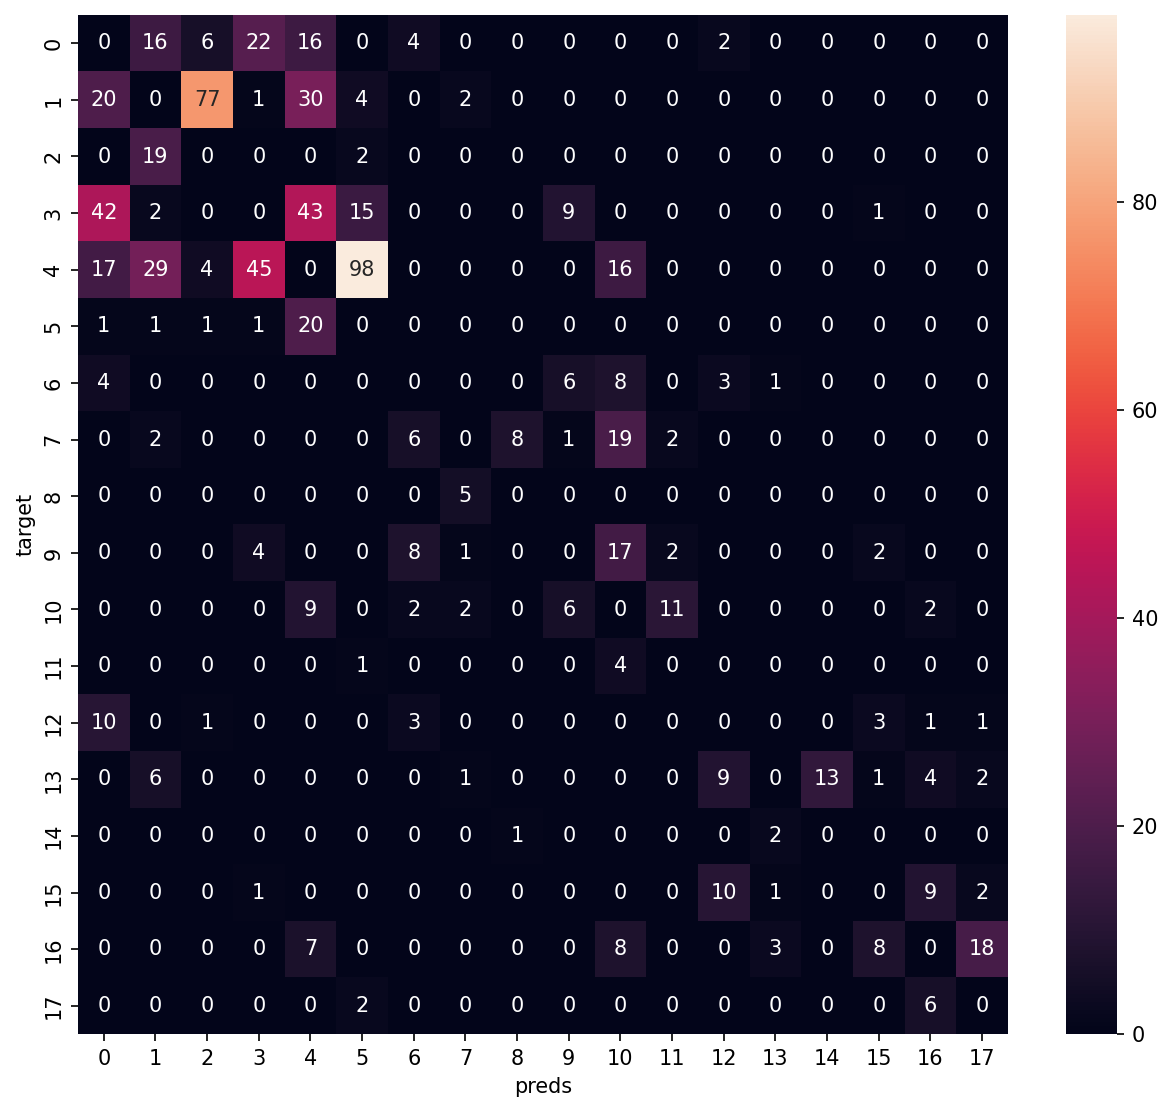

In [123]:
plt.figure(dpi=150, figsize=(10,9))
ax = sns.heatmap(mat_masked, annot=True, fmt='g')
ax.set_xlabel('preds')
ax.set_ylabel('target')

Text(144.58333333333331, 0.5, 'target')

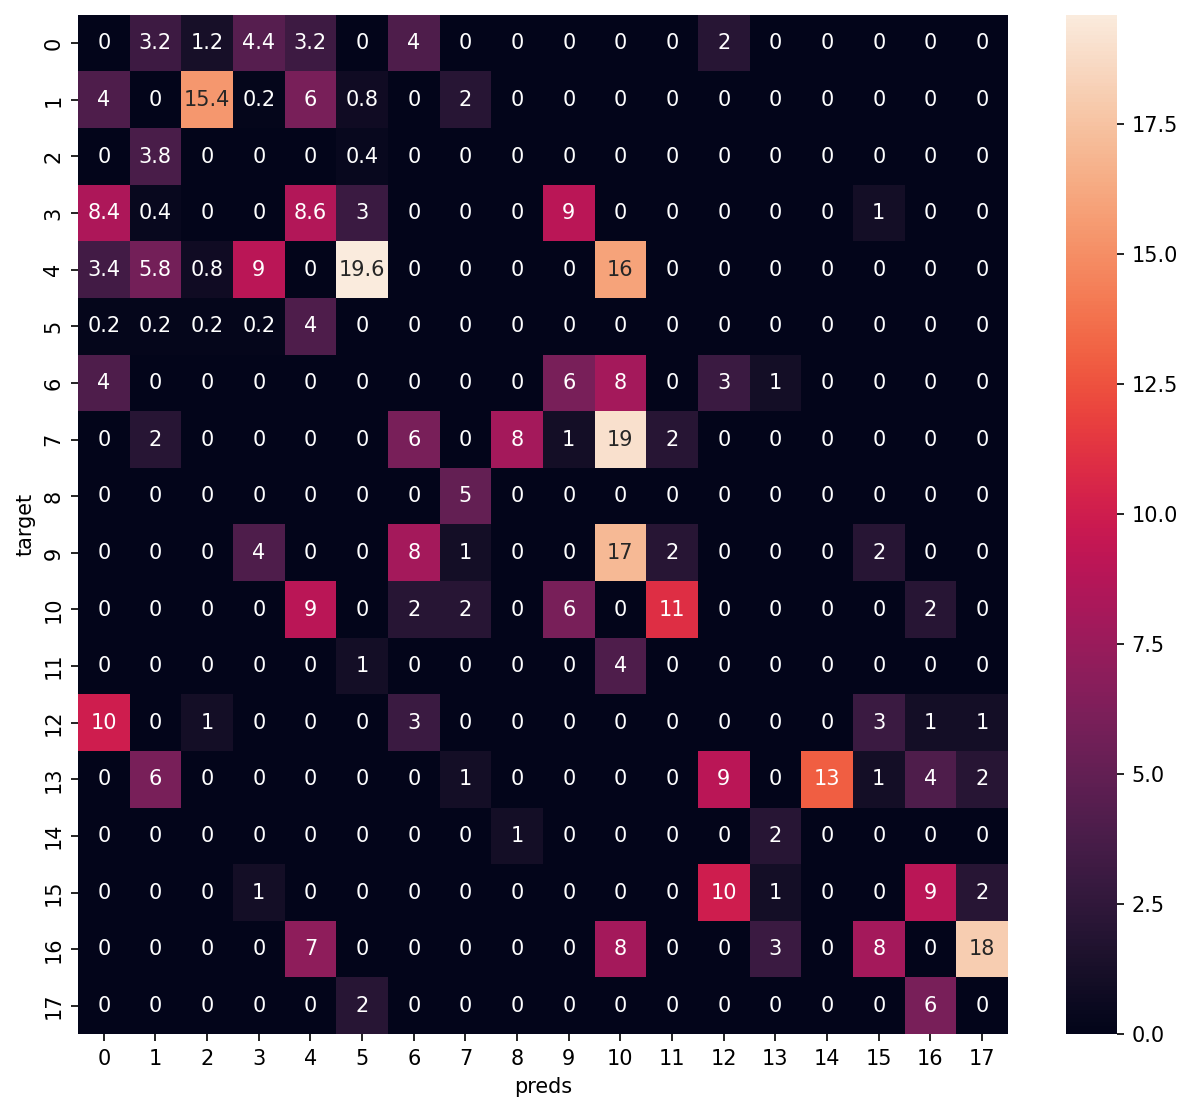

In [127]:
# 마스크 쓴 데이터가 5개이므로, 5로 나눠준 것
mat_norm = mat_masked.copy()
mat_norm[:6, :6] /= 5
plt.figure(dpi=150, figsize=(10,9))
ax = sns.heatmap(mat_norm, annot=True, fmt='g')
ax.set_xlabel('preds')
ax.set_ylabel('target')

In [102]:
mask_mat = np.zeros((3,3))
for i in range(18):
    for j in range(18):
        ii = i // 6
        jj = j // 6
        mask_mat[ii][jj] += mat[i][j]

mask_mat

array([[1.3466e+04, 3.1000e+01, 3.0000e+00],
       [2.0000e+01, 2.6720e+03, 8.0000e+00],
       [2.7000e+01, 1.3000e+01, 2.6600e+03]])

Text(0.5, 1.0, 'mask')

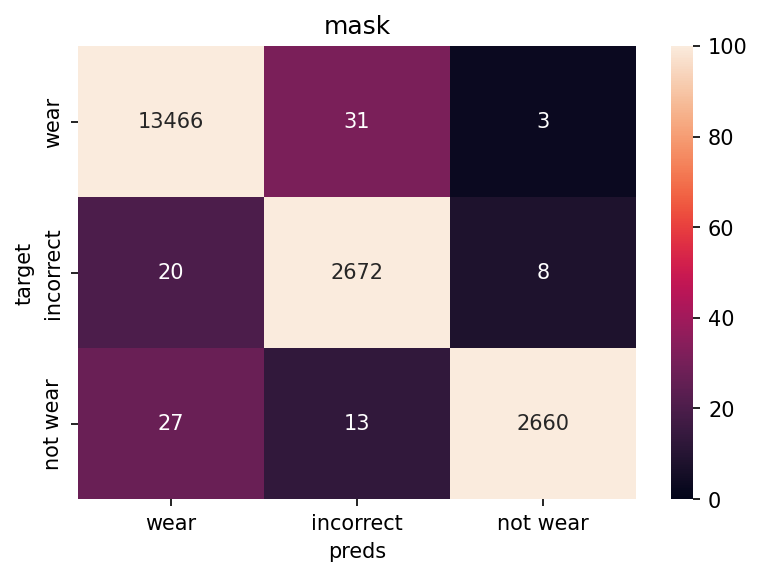

In [129]:
plt.figure(dpi=150)

labels = ['wear', 'incorrect', 'not wear']

ax = sns.heatmap(mask_mat, annot=True, xticklabels=labels, yticklabels=labels, fmt='g',
                vmin=0, vmax=100)
ax.set_xlabel('preds')
ax.set_ylabel('target')
ax.set_title('mask')

In [104]:
gender_mat = np.zeros((2,2))
for i in range(18):
    for j in range(18):
        ii = i % 6 // 3
        jj = j % 6 // 3
        gender_mat[ii][jj] += mat[i][j]
gender_mat

array([[ 7171.,   123.],
       [  124., 11482.]])

Text(0.5, 1.0, 'gender')

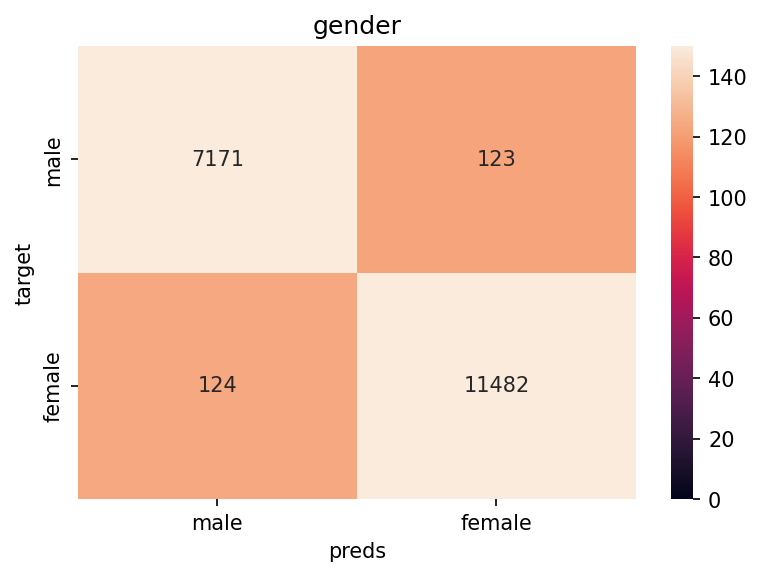

In [128]:
plt.figure(dpi=150)
labels = ['male', 'female']

ax = sns.heatmap(gender_mat, annot=True, xticklabels=labels, yticklabels=labels, fmt='g',
                vmin=0, vmax=150)
ax.set_xlabel('preds')
ax.set_ylabel('target')
ax.set_title('gender')

In [109]:
age_mat = np.zeros((3,3))
for i in range(18):
    for j in range(18):
        ii = i % 3
        jj = j % 3
        age_mat[ii][jj] += mat[i][j]
age_mat

array([[8.825e+03, 1.150e+02, 2.700e+01],
       [1.160e+02, 8.236e+03, 2.370e+02],
       [2.000e+00, 5.700e+01, 1.285e+03]])

Text(0.5, 1.0, 'age')

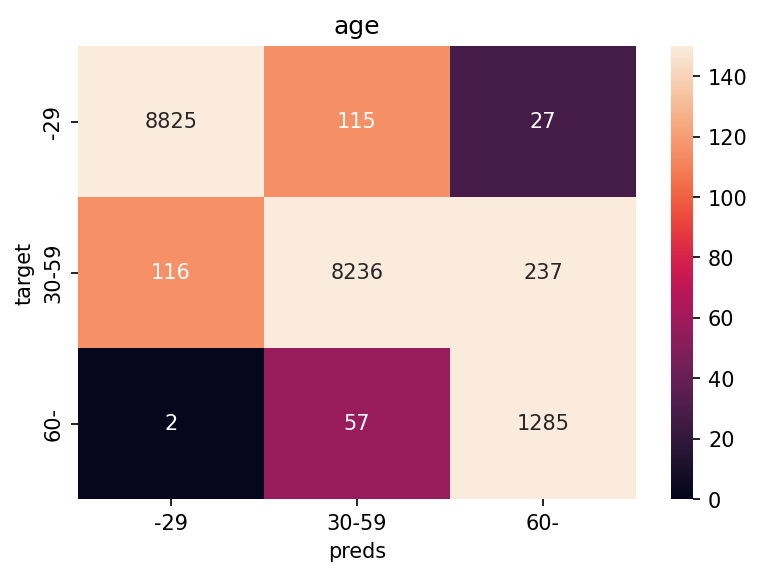

In [130]:
plt.figure(dpi=150)

labels = ['-29', '30-59', '60-']

ax = sns.heatmap(age_mat, annot=True, xticklabels=labels, yticklabels=labels, fmt='g', vmin=0, vmax=150)
ax.set_xlabel('preds')
ax.set_ylabel('target')
ax.set_title('age')